In [1]:
import pandas as pd

from src.populate_db import connect_to_database
from src.analisis_utils import plot_activity_years, create_crosstable_heatmap, plot_choropleth_map

import warnings
warnings.filterwarnings('ignore')


# Exploring bands in the dataset

This notebook will answer some basic questions about the bands in the database:
- How many bands are there in the database?
- During which years these bands were active?
- For how many years the bands are usually active?
- What are the bands' country of origin?
- How many new bands were created per country across decades?

Let's query the database and load the data into a dataframe.

In [2]:
conn = connect_to_database()
cursor = conn.cursor()
cursor.execute("""
               SELECT band.name, band.country, YEAR(band.start_date) - MOD(YEAR(band.start_date), 10) AS start_decade, 
               YEAR(band.start_date) AS start_year, 
               YEAR(band.end_date) AS end_year 
               FROM band;
               """)
result = cursor.fetchall()

In [3]:
result_df = pd.DataFrame(result, columns=['Band', 'Country', 'Decade', 'Start', 'End'])
df = result_df.dropna(subset=["Start"])
df = df[df['Band'] != '']
df['Decade'] = df.Decade.astype(int)
df['Start'] = df.Start.astype(int)
df['End'] = df.End.fillna(2024).astype(int)

## How many bands are there in the database?

As we can see, there are 8,340 unique bands in the database, but only 4,994 have information about start decade.

In [4]:
print(f"Number of unique Bands: {result_df.Band.nunique()}")
print(f"Number of Bands with information about decade: {df.Band.nunique()}")

Number of unique Bands: 8340
Number of Bands with information about decade: 4994


## During which years these bands were active?

Let's first take a look at the distribution of decades in which the bands started.

As we can see, the number of metal bands started growing since the 80's. The majority of them started in the 90's, closely followed by the 00's. The number of new bands significantly decreased since then.

<Axes: xlabel='Decade'>

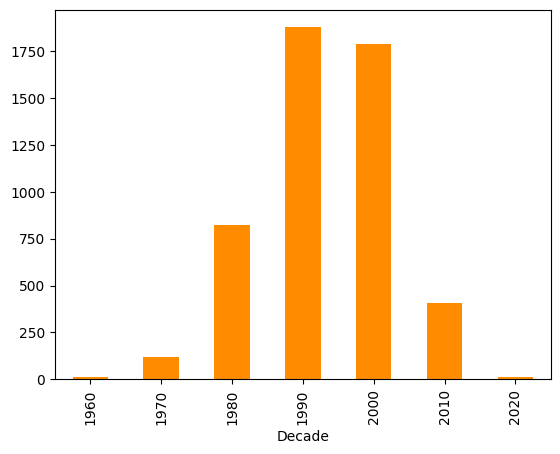

In [5]:
df.Decade.value_counts().sort_index().plot(kind='bar', color='darkorange')

Regarding the bands' activity, the plot below shows that most of the bands in the database are still active.

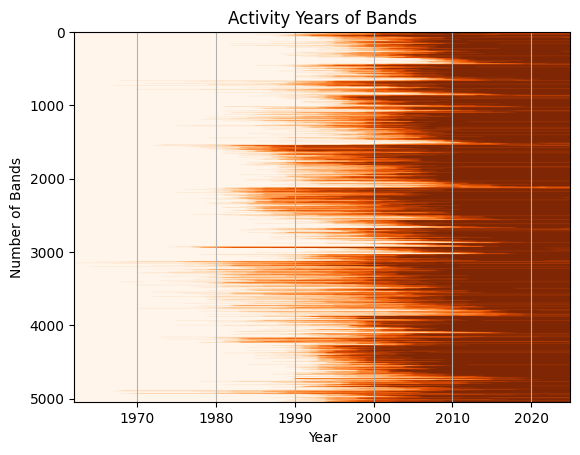

In [6]:
plot_activity_years(df)

Now let's filter only the bands that ended before 2024.

The number of bands that have ended is only 107. The activity plot for these bands show that they were mostly active during the 90's and 00's.

In [7]:
active = df['End'] == 2024
df['Active'] = active
print(f"Number of bands which ended before 2024: {len(df[df['Active'] == False])}")

Number of bands which ended before 2024: 107


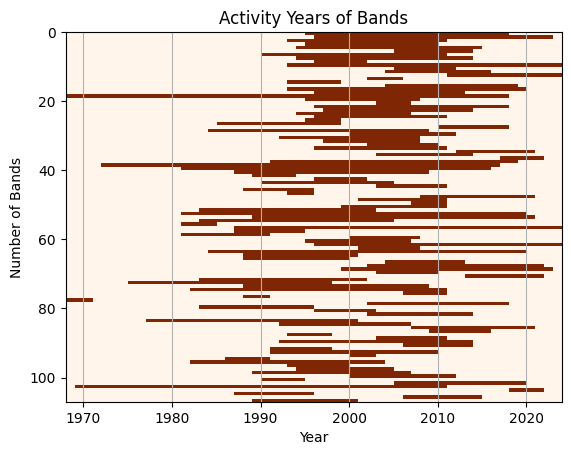

In [8]:
plot_activity_years(df[df['Active'] == False])

## For how many years the bands are usually active?

Let's calculate the duration of activity for bands and then plot the results.

In [9]:
df['Duration'] = df['End'] - df['Start']
df = df.loc[df['Duration'] > 0]

<Axes: title={'center': 'Duration of active bands'}, ylabel='Frequency'>

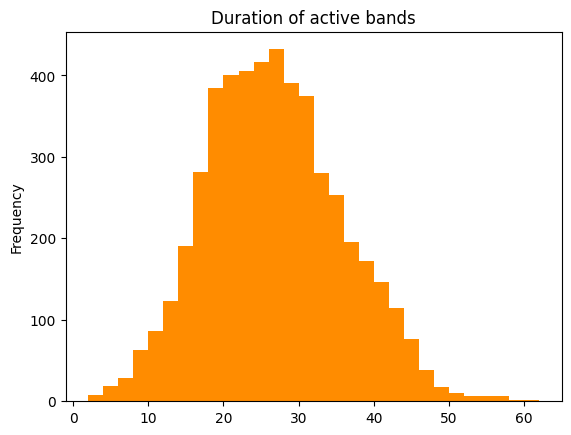

In [10]:
df[df['Active'] == True]['Duration'].plot(kind='hist', color='darkorange', bins=30, title='Duration of active bands')

<Axes: title={'center': 'Duration of inactive bands'}, ylabel='Frequency'>

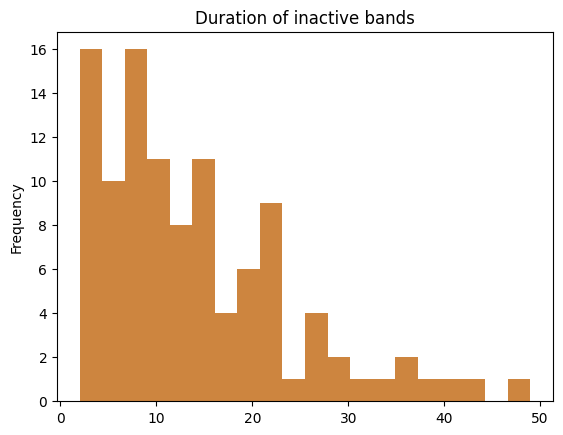

In [11]:
df[df['Active'] == False]['Duration'].plot(kind='hist', color='peru', bins=20, title='Duration of inactive bands')

While the distribution of active bands has a duration that averages around 20-30 years, a large proportion of the inactive bands had a duration of up to 15 years. However, a small number of inactive bands had a longevity of many decades, including a few very famous bands that recently retired.


In [12]:
df[df['Active'] == False].sort_values(by='Duration', ascending=False).head(15)

,Band,Country,Decade,Start,End,Active,Duration
660,Black Sabbath,United Kingdom,1960,1968,2017,False,49
1542,Twisted Sister,United States of America,1970,1972,2016,False,44
4924,Thin Lizzy,Republic of Ireland,1960,1969,2010,False,41
2124,Slayer,United States of America,1980,1981,2019,False,38
2257,Equinox,Norway,1980,1987,2023,False,36
2688,Soundgarden,United States of America,1980,1984,2019,False,35
1549,Mötley Crüe,United States of America,1980,1981,2015,False,34
2125,Absu,United States of America,1980,1989,2020,False,31
73,Jack Frost,Austria,1990,1993,2023,False,30
3156,Dio,United States of America,1980,1982,2010,False,28


## What are the bands' country of origin?

The map below shows the number of bands by country of origin. We can see that the United States has by far the most bands, followed by Germany, Sweden, the Netherlands, Finland, and the UK.

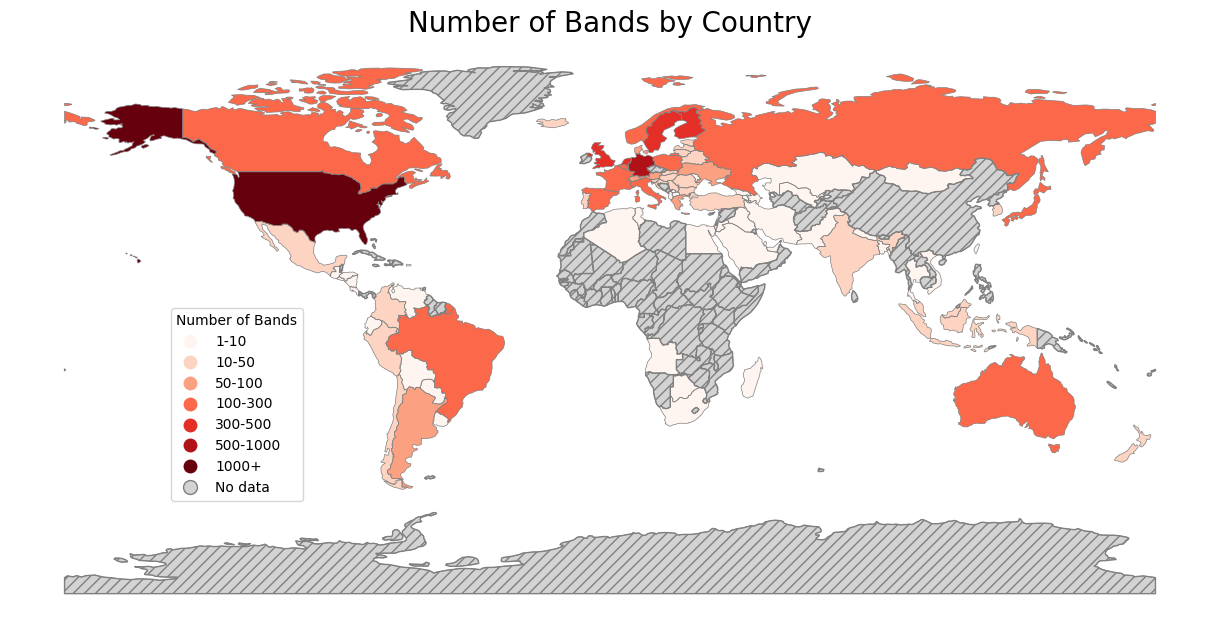

In [13]:
plot_choropleth_map(result_df, 'Band')

## How many new bands were created per country across decades?

To answer this question, let's select the top 20 countries in number of bands. See the heatmap below.

As expected, the United States has the lead in number of bands during the most decades. However, the data shows that in the early days of metal the United Kingdom was the major producer of bands. In the 90's, we see a surge of bands also in Sweden, Poland, Germany, and Finland. After the 10's, there is a significant drop in the number of new bands created across all countries.

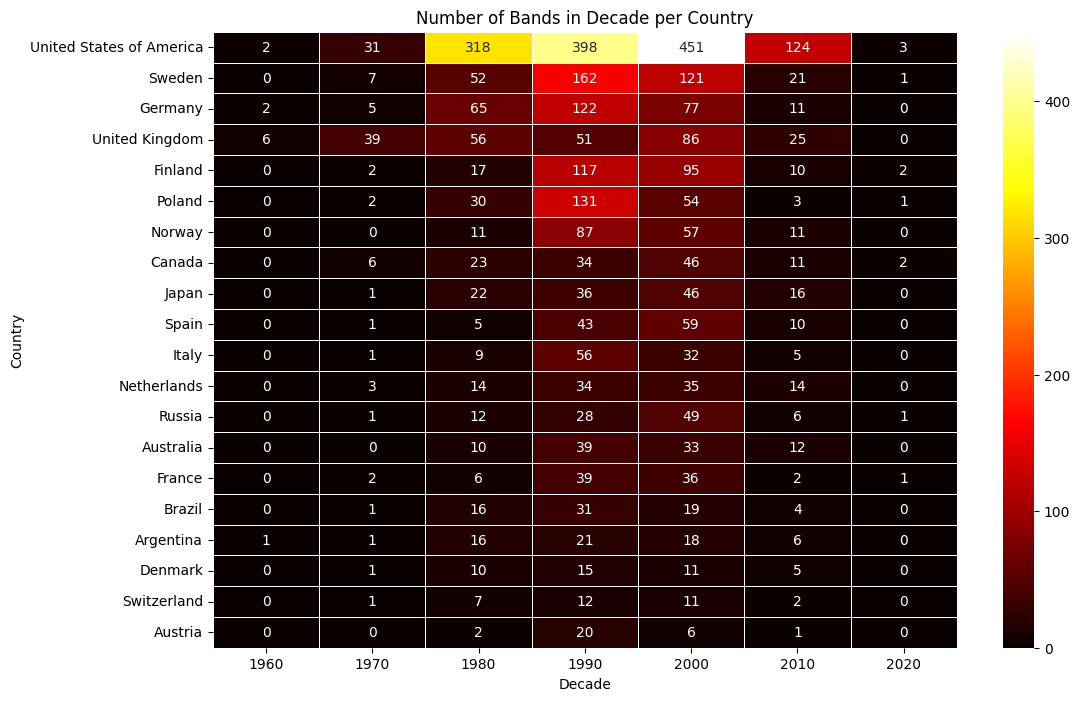

In [14]:
cross_country_decade = create_crosstable_heatmap(df, 'Country', 'Decade', 20)